# OSEMN Machine Learning, Random Forest Classification (Wine Dataset)

# Table of Contents
1. [Main Dataset with Explicit OSEMN Delineation about Wine Reviews](#Wine-Description-Length-to-Classify-Point-Rating-and-Price)
2. [Supplemental Dataset without Explicit OSEMN Delineation about Wine Chemistry](#Phenolics:-Wine-Classification-From-A-Chemistry-Perspective)


In [1]:
#import all necessary libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Imputer,LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import warnings
warnings.filterwarnings("ignore")

## Obtain

## Wine Description Length to Classify Point Rating and Price

In [2]:
#import main wine dataset, set index to eliminate superfluous Primary Key Column
winedf = pd.read_csv('wine-data/winemag-data-130k-v2.csv', index_col=0)
winedf.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Scrub

In [3]:
# function to investigate missing values in wine dataset 
def MissingValues(df): #creating the function
    total = df.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (df.isnull().sum() / df.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print(df[~(df['Total'] == 0)])# Returning values of nulls different of 0
    
    return

MissingValues(winedf)

                       Total    Percent
region_2               79460  61.136715
designation            37465  28.825661
taster_twitter_handle  31213  24.015357
taster_name            26244  20.192197
region_1               21247  16.347493
price                   8996   6.921544
province                  63   0.048472
country                   63   0.048472
variety                    1   0.000769


In [4]:
#Full list of Features, with or without missing data
winedf.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [5]:
#Narrow down the data to my two features of interest and target variable, clean data
winedf = winedf[['points', 'price', 'description']].copy()
winedf = winedf.dropna().reset_index(drop=True)

In [6]:
len(winedf)

120975

In [7]:
# I check for duplicates, which is often valuable, but in this case it reduces the dataset by a factor of 5
# This removes too many values, will come back to if there is time
# winedf = winedf[winedf.duplicated('description', keep=False)]

# len(winedf) after duplicated removed = 20026, not worth performing this operation

## Explore

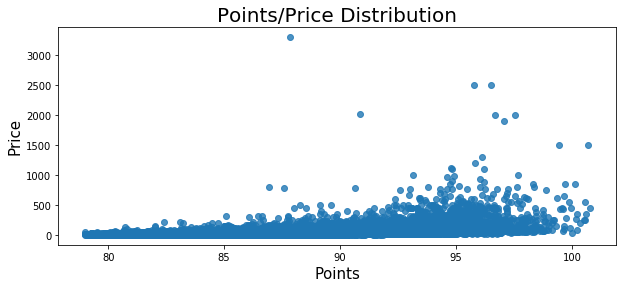

In [8]:
#Some outliers to take note of
plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price', data=winedf, x_jitter=True, fit_reg=False)
g.set_title("Points/Price Distribution", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price", fontsize= 15)

plt.show()

In [9]:
#Creates a new column which will be used in modeling
#by getting the word count of each wine description as a variable
winedf2 = winedf.assign(desc_length = winedf['description'].apply(len))
winedf2.head()

,points,price,description,desc_length
0,87,15.0,"This is ripe and fruity, a wine that is smooth...",227
1,87,14.0,"Tart and snappy, the flavors of lime flesh and...",186
2,87,13.0,"Pineapple rind, lemon pith and orange blossom ...",199
3,87,65.0,"Much like the regular bottling from 2012, this...",249
4,87,15.0,Blackberry and raspberry aromas show a typical...,261


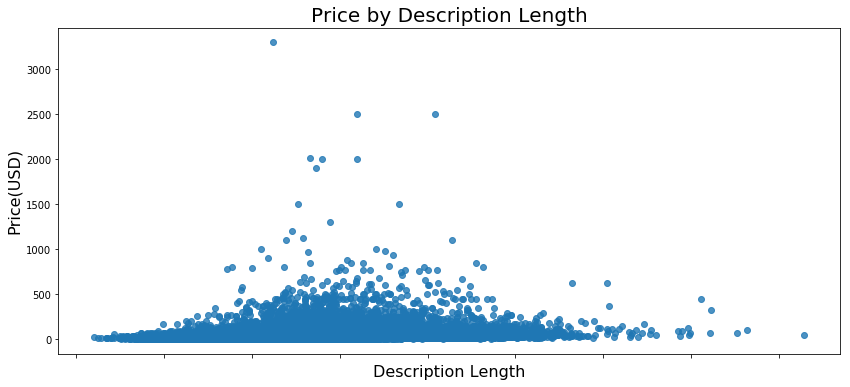

In [10]:
# Compare Description Length to Price
plt.figure(figsize=(14,6))
g = sns.regplot(x='desc_length', y='price', data=winedf2, fit_reg=False)
g.set_title('Price by Description Length', fontsize=20)
g.set_ylabel('Price(USD)', fontsize = 16) 
g.set_xlabel('Description Length', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

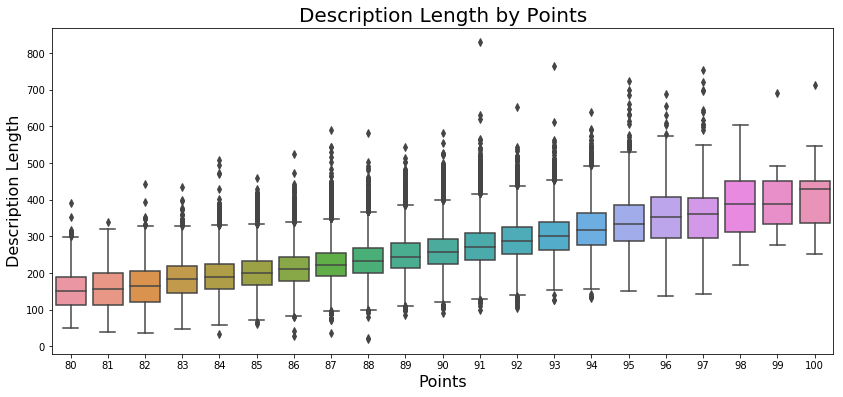

In [11]:
#This foreshadows that Classification may not be best model here. 
#A Linear Regression would likely be a more precise model, 
#but let's put it to a classification test to be sure
plt.figure(figsize=(14,6))
g = sns.boxplot(x='points', y='desc_length', data=winedf2)
g.set_title('Description Length by Points', fontsize=20)
g.set_ylabel('Description Length', fontsize = 16) # Y label
g.set_xlabel('Points', fontsize = 16) # X label
plt.show()

Text(0, 0.5, 'Count')

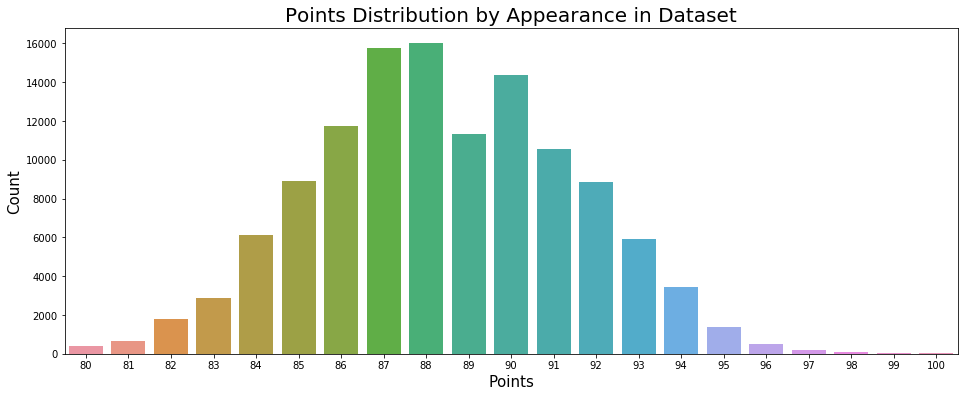

In [12]:
#Graphing to see how points are distributed visually, to get a better sense of how to group them when simplifying
plt.figure(figsize=(16,6))
g = sns.countplot(x='points', data=winedf)
g.set_title("Points Distribution by Appearance in Dataset", fontsize=20) 
g.set_xlabel("Points", fontsize=15) 
g.set_ylabel("Count", fontsize=15)

In [13]:
#Working with so many points and prices can make modeling difficult. I will demonstrate this
#with my first entry in the next section, but for now I will create some functions that help me
#narrow down the points and prices

#Method taking points as param and simplifying them into 5 categories
def points_simplified(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 5

#Method taking price as param, making binary split on 100, as this is an important
#threshold in the wine industry on price versus quality
def price_simplified(price):
    if price < 100:
        return 0
    else:
        return 1
    
#Applying transform method and assigning result to new column "points_simplified"
winedf2 = winedf2.assign(points_simplified = winedf2['points'].apply(points_simplified))
#Apply another transform method, assigning result to new column "price_simplified"
winedf2 = winedf2.assign(price_simplified = winedf2['price'].apply(price_simplified))

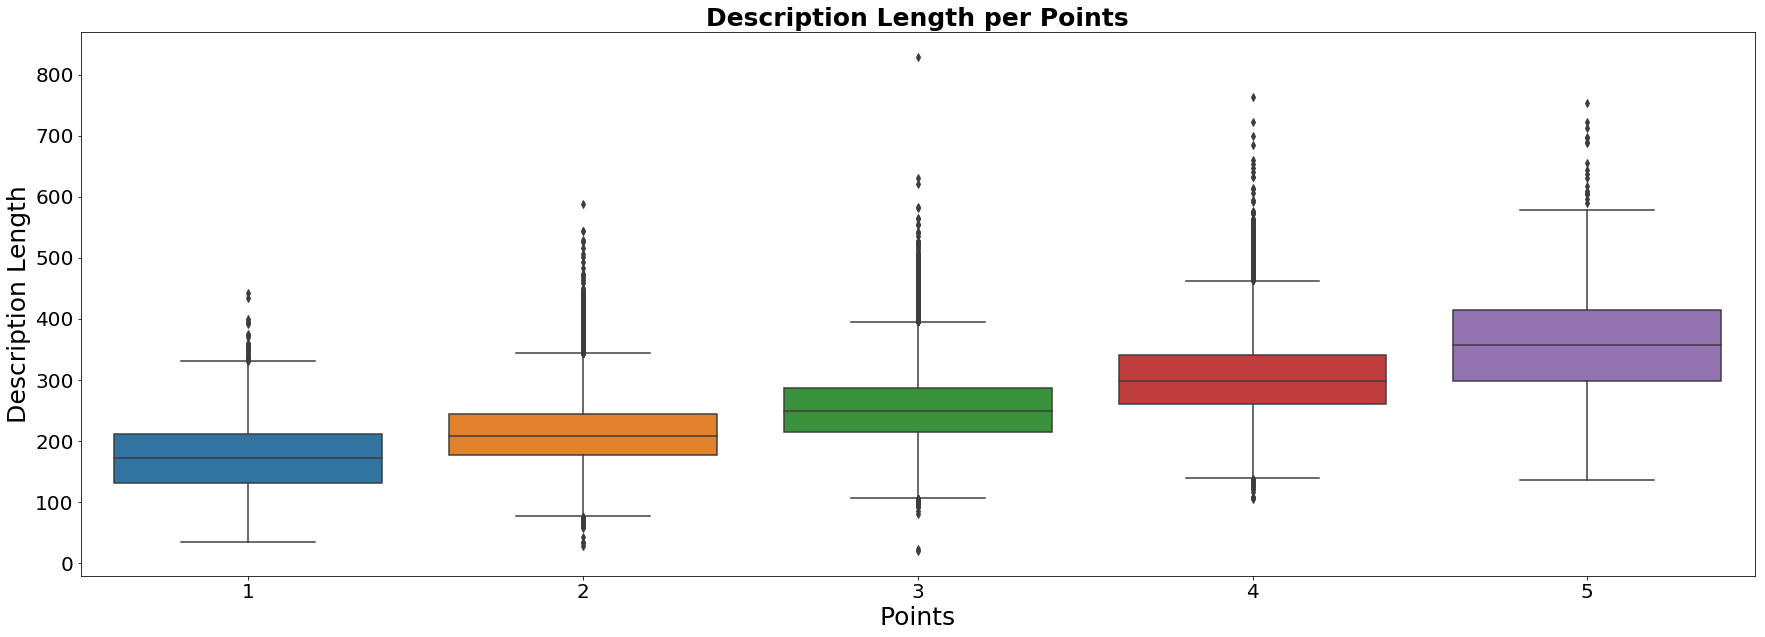

In [14]:
#Visualize our two newly transformed variables 

#First, description length & points binned into 5 categories
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points_simplified', y='desc_length', data=winedf2)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) 
ax.set_ylabel('Description Length', fontsize = 25)
ax.set_xlabel('Points', fontsize = 25) 
plt.show()

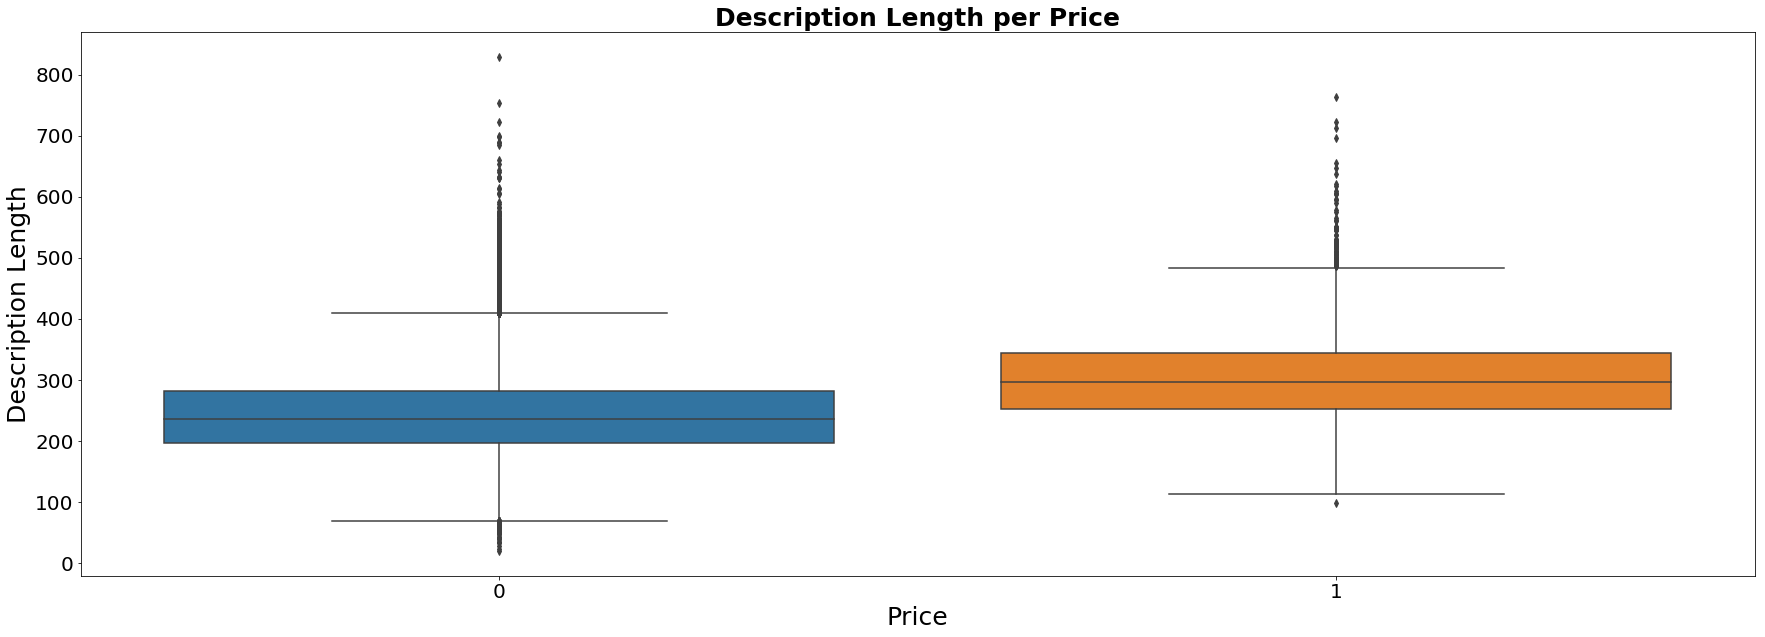

In [15]:
#Then, the price binary
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='price_simplified', y='desc_length', data=winedf2)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Price', fontweight="bold", size=25) 
ax.set_ylabel('Description Length', fontsize = 25)
ax.set_xlabel('Price', fontsize = 25) 
plt.show()

## Model 

#### Points/Description Length

In [16]:
#First, I try the Random Forest Classifier model without any kind of scaling simply to demonstrate 
#the need both for scaling and for creating the simplifications I made in my EDA section above

# Training the model
X = winedf2.iloc[:,-1:] # This is the last column I created above, desc_length for description length
y = winedf2['points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
# Very imprecise.
print(classification_report(y_test, predictions))
#Very inaccurate
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

          80       0.00      0.00      0.00        95
          81       0.00      0.00      0.00       159
          82       0.00      0.00      0.00       417
          83       0.00      0.00      0.00       692
          84       0.00      0.00      0.00      1566
          85       0.00      0.00      0.00      2231
          86       0.00      0.00      0.00      2971
          87       0.00      0.00      0.00      3953
          88       0.13      0.99      0.24      3950
          89       0.00      0.00      0.00      2857
          90       0.00      0.00      0.00      3607
          91       0.00      0.00      0.00      2649
          92       0.00      0.00      0.00      2163
          93       0.00      0.00      0.00      1511
          94       0.18      0.22      0.20       864
          95       0.00      0.00      0.00       357
          96       0.00      0.00      0.00       130
          97       0.00    

In [17]:
# Training the model
# X = desc_length 
#(our same X from before)
y = winedf2['points_simplified'] # and simplified points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1363
           2       0.00      0.00      0.00     10721
           3       0.44      0.98      0.61     13063
           4       0.60      0.13      0.21      4895
           5       0.00      0.00      0.00       202

   micro avg       0.44      0.44      0.44     30244
   macro avg       0.21      0.22      0.16     30244
weighted avg       0.29      0.44      0.30     30244

Overall Accuracy:  0.44352598862584314


In [18]:
#Scaling the wine description length
scaler=MinMaxScaler()
scaled_wine=scaler.fit_transform(winedf2[['desc_length']])
foo=pd.DataFrame(scaled_wine)
X=foo[0]
y=winedf2.points_simplified

In [19]:
#Scaling the wine description length gives a negligible performance boost
scaler=MinMaxScaler()
scaled_wine=scaler.fit_transform(winedf2[['desc_length']])
newdf=pd.DataFrame(scaled_wine)
X=newdf[0]
y=winedf2.points_simplified

# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           1       0.60      0.12      0.20      1363
           2       0.57      0.53      0.55     10721
           3       0.51      0.69      0.59     13063
           4       0.49      0.25      0.33      4895
           5       0.20      0.02      0.04       202

   micro avg       0.53      0.53      0.53     30244
   macro avg       0.47      0.32      0.34     30244
weighted avg       0.53      0.53      0.51     30244

Overall Accuracy:  0.5289313582859411


#### Price/Description Length

In [20]:
#As long as you are predicting for wines below $100, this is an excellent classifier
X = winedf2.desc_length
y = winedf2.price_simplified
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(np.array(y_test).reshape(-1,1), predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     29197
           1       0.40      0.00      0.01      1047

   micro avg       0.97      0.97      0.97     30244
   macro avg       0.68      0.50      0.49     30244
weighted avg       0.95      0.97      0.95     30244

Overall Accuracy:  0.9653154344663404


In [48]:
#I use MinMax scaling in my analysis here, but Standard scaling gives comparable 
#albeit slightly less accuracy/precision in training/testing performed outside of this notebook
scaler=MinMaxScaler()
scaled_wine=scaler.fit_transform(winedf2[['desc_length']])
newdf=pd.DataFrame(scaled_wine)
X=newdf[0]
y=winedf2.price_simplified
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(np.array(y_test).reshape(-1,1), predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     29197
           1       0.36      0.00      0.01      1047

   micro avg       0.97      0.97      0.97     30244
   macro avg       0.66      0.50      0.50     30244
weighted avg       0.94      0.97      0.95     30244

Overall Accuracy:  0.9652493056474012


In [22]:
#Trying to exclude some of the extreme upper outliers for price
#This makes the model much less accurate. I will reflect on possible reasons in the next section
y = winedf2[winedf2['price'] <= 500]['price']
X = winedf2[winedf2['price'] <= 500]['desc_length']
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

Overall Accuracy:  0.055425035571291484


## Interpret

**Description Length to Classify Points:**

In [56]:
# A possible explanation for the unsimplified points versus description length model
# could be that I am using a classification model, Random Forest, versus Linear Regression. The data still is somewhat
# linear after simplification of points into 5 categories, but I think classification holds up better
# because there is less noise from the presence of fewer categories in the dependent variable.

# That being said, this improvement in performance only brought the model to an only slightly better than chance
# level of accuracy and precision. I would maintain that linear regression is probably the way to go here,
# but this of course merits further testing to say for sure.

**Description Length to Classify Price:**

In [23]:
# Moving on to an interpretation of my price as dependent variable model, the most notable thing to mention is that
# the model is highly accurate for wines underneath $100. It is not accurate above that, something I tried to address 
# through going back to my EDA and determining where a good cutoff for outliers would be. I chose $500 in the previous 
# section as that cutoff. This was not a successful refinement of the model, and produced very low accuracy.

# This was something I tested and tried to get working outside of this final notebook for the project, and did not 
# find eliminating outliers on at other prices produced any better outcomes. The model works reasonably well, but
# only when dealing with the entire dataset and I am still uncertain as to how to interpret this.

# Fortunately, I put forth that the vast majority of wine drinkers are never looking to spend more than $100 on 
# a bottle, or to do so only very infrequently. This model shows that wines of a certain description length from this 
# dataset are able to be classified with high precision and accuracy through the Random Forest Algorithm. 

**Conclusions**

In [ ]:
# Taken together, I contend that these two results should be interpreted to mean that buying wine with longer
# description length that is still under $100 for the bottle is the best approach. Since it was the weaker model,
# point rating should only be used as a secondary way to classify which are truly the best wines.

## Phenolics: Wine Classification From A Chemistry Perspective

#### As I have already dilineated the five stages of the Data Science lifecycle (OSEMN), I will not do so here

In [51]:
#import supplemental dataset about phenolics
winedf1 = pd.read_csv('winequality-red.csv')
winedf1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [52]:
#Useful when defining number of estimators parameter later
winedf1.shape

(1599, 12)

In [53]:
#Empty DataFrame = no missing values, see previous dataset's scrubbing section for function
MissingValues(winedf1)

Empty DataFrame
Columns: [Total, Percent]
Index: []


Text(0, 0.5, 'Count')

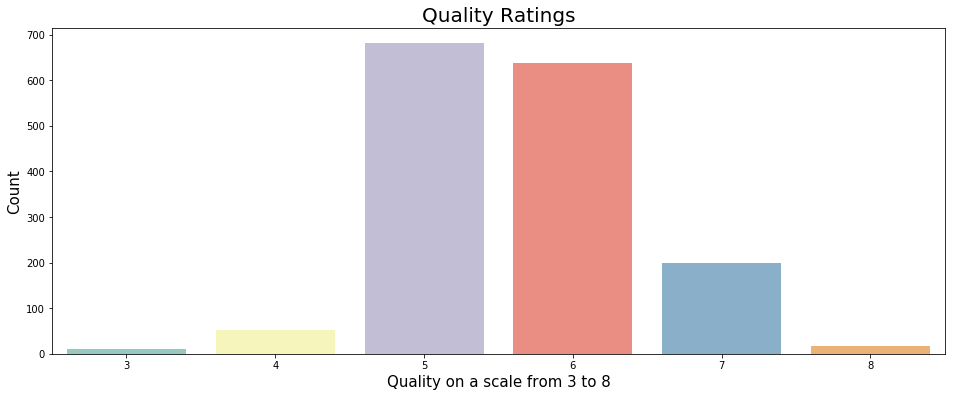

In [54]:
# This shows the best place to split on if wine is good or bad is just above 6, say 6.25
plt.figure(figsize=(16,6))
g = sns.countplot(x='quality', data=winedf1, palette='Set3')
g.set_title("Quality Ratings", fontsize=20) # Graph title
g.set_xlabel("Quality on a scale from 3 to 8", fontsize=15) #X-axis label
g.set_ylabel("Count", fontsize=15) #Y-axis label

In [28]:
#Best cutoff point for my Trader Joe binary
bins = (2, 6.5, 8)
group_names = ['twobuckchuck', 'nottwobuckchuck']
winedf1['quality'] = pd.cut(winedf1['quality'], bins = bins, labels = group_names)

In [29]:
label_quality = LabelEncoder()

In [30]:
#Bad becomes 0 and good becomes 1 
winedf1['quality'] = label_quality.fit_transform(winedf1['quality'])

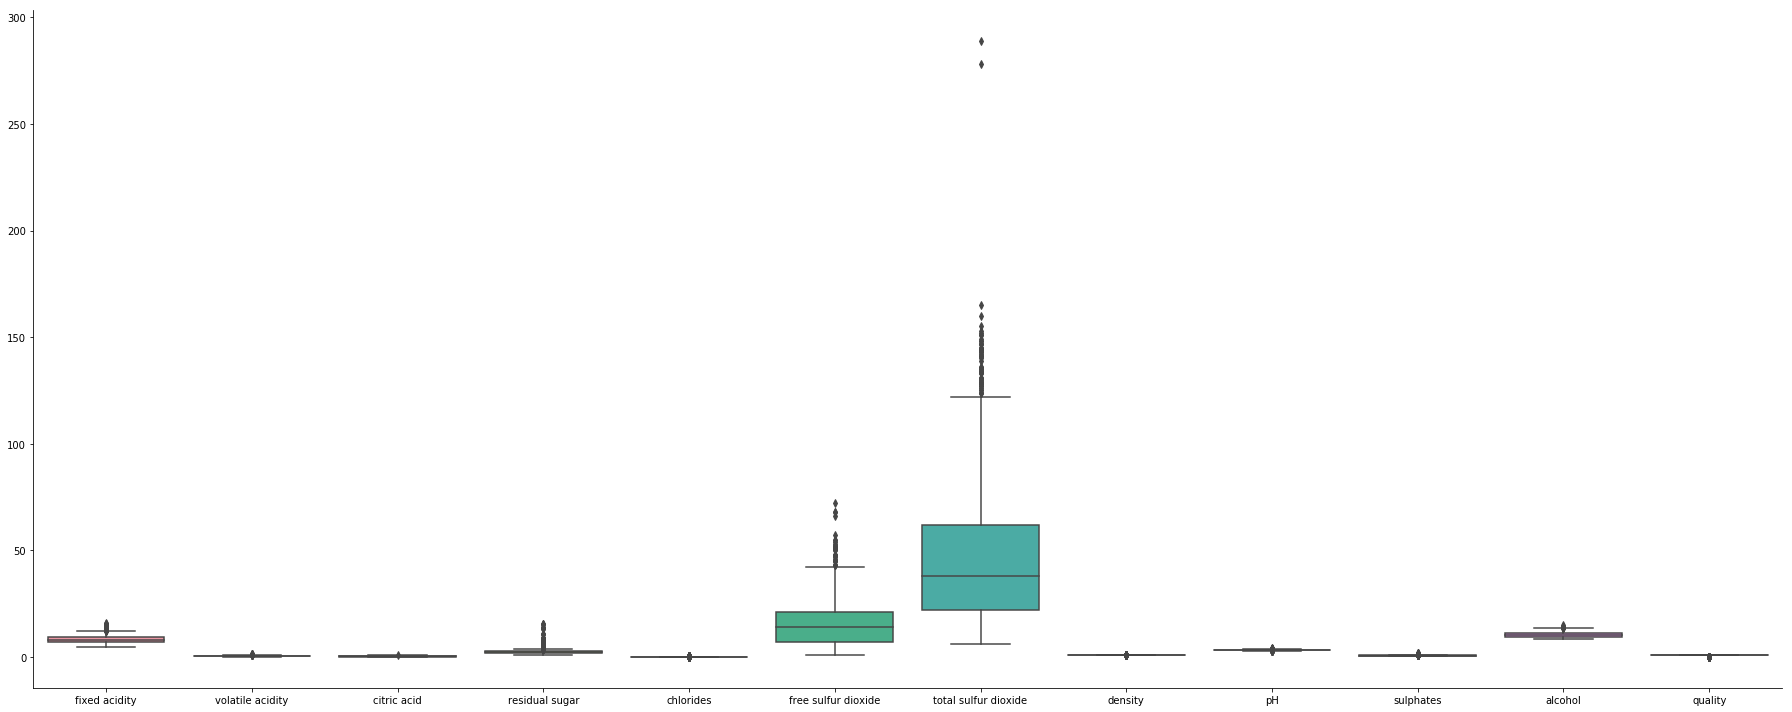

In [31]:
# All but two of the variables are distributed over a very small scale
sns.factorplot(data=winedf1,kind='box',size=10,aspect=2.5)

In [32]:
#Let's visualize how the dataset looks after scaling
scaler=MinMaxScaler()
scaled_df=scaler.fit_transform(winedf1)
scaled_df = pd.DataFrame(scaled_df, columns=winedf1.columns)

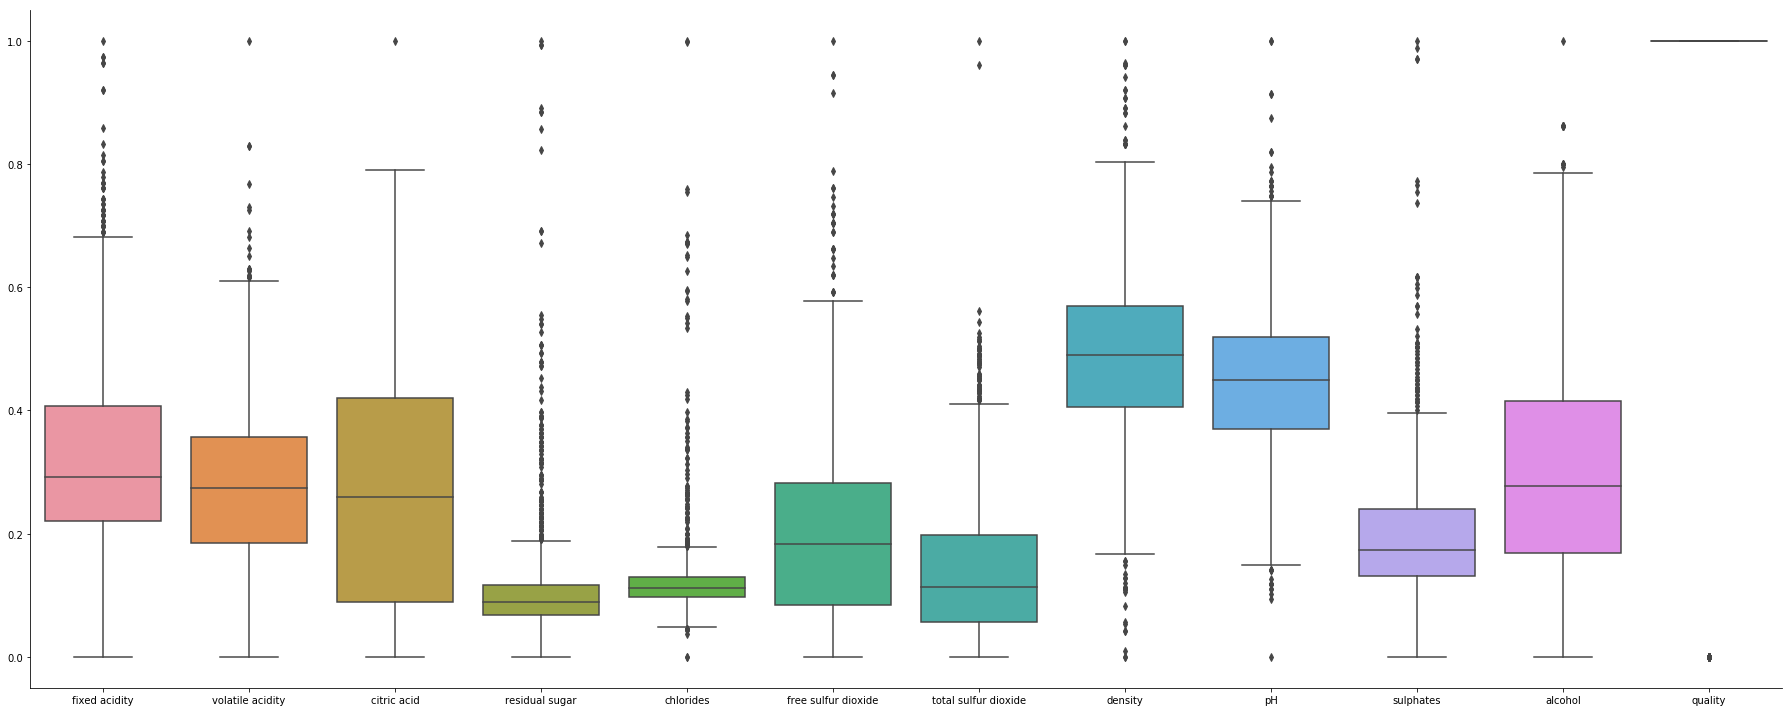

In [33]:
#Seems to just inject more reducible error into model, although this will be tested
sns.factorplot(data=scaled_df,kind='box',size=10,aspect=2.5)
#Quality has successfully been binarized

In [34]:
#All Features As X
x_train,x_test,y_train,y_test=train_test_split(winedf1.drop('quality',axis=1),winedf1['quality'],test_size=0.25,random_state=42)

In [35]:
#All features very effective for classifying wine that is better than two-buck chuck
rfc = RandomForestClassifier()
rfc.fit(np.array(x_train), np.array(y_train))
predictions = rfc.predict(np.array(x_test))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.60      0.60        53
           1       0.94      0.94      0.94       347

   micro avg       0.89      0.89      0.89       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.89      0.89      0.89       400

Overall Accuracy:  0.8925


In [36]:
#Iterating through to see the best score using a GridSearch 10 fold Cross-Validation
params_dict={'n_estimators':[1599],'max_features':['auto','sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),param_grid=params_dict,scoring='accuracy',cv=10)
clf_rf.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1599], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [37]:
#Best training score
clf_rf.best_score_

0.9124270225187656

In [38]:
#Actual accuracy on test set
pred=clf_rf.predict(x_test)
accuracy_score(pred,y_test)  

0.9025

In [39]:
#Preparing the all-features model to see how it performs with MinMax Scaling
scaler=MinMaxScaler()
scaled_df=scaler.fit_transform(winedf1)
X=scaled_df[:,:11]
Y=winedf1['quality'].values
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [40]:
#Still a very accurate classifier of wine that is of better quality than two-buck chuck
rfc = RandomForestClassifier()
rfc.fit(np.array(x_train), np.array(y_train))
predictions = rfc.predict(np.array(x_test))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.55      0.55        53
           1       0.93      0.93      0.93       347

   micro avg       0.88      0.88      0.88       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.88      0.88      0.88       400

Overall Accuracy:  0.8825


In [41]:
#Iterating through to see the best score using a GridSearch 10 fold Cross-Validation
params_dict={'n_estimators':[1599],'max_features':['auto','sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),param_grid=params_dict,scoring='accuracy',cv=10)
clf_rf.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1599], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [42]:
#Best training score
clf_rf.best_score_

0.9132610508757297

In [43]:
#Actual accuracy on test set
pred=clf_rf.predict(x_test)
accuracy_score(pred,y_test)   

0.9025

##### Whether dealing with "good" or "bad" wine, Random Forest is quite a precise and accurate Machine Learning classification model. It is particularly good at distinguising what makes a "good" wine (which I define as "nottwobuckchuck" below the Quality Ratings graph). 

##### Feature scaling is always something worth applying when analyzing datasets. However in this specific instance, all of the features were very uniform even before scaling. Just to be even more certain that the classification model is sound, I will perform some additional tests surrounding the free and total sulphur dioxide metrics and their interplay with performance, both with and without MinMax Scaling.


In [44]:
#Test with only free sulphur dioxide and total sulphur dioxide, the two standouts from my EDA
x_train,x_test,y_train,y_test=train_test_split(winedf1.iloc[:,5:7],winedf1['quality'],test_size=0.25,random_state=42)
rfc = RandomForestClassifier()
rfc.fit(np.array(x_train), np.array(y_train))
predictions = rfc.predict(np.array(x_test))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.32      0.35        53
           1       0.90      0.93      0.91       347

   micro avg       0.84      0.84      0.84       400
   macro avg       0.65      0.62      0.63       400
weighted avg       0.83      0.84      0.84       400

Overall Accuracy:  0.845


In [45]:
#Same two features tested with MinMax Scaling
scaler=MinMaxScaler()
scaled_df=scaler.fit_transform(winedf1)
X=scaled_df[:,5:7]
Y=winedf1['quality'].values
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
rfc.fit(np.array(x_train), np.array(y_train))
predictions = rfc.predict(np.array(x_test))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.41      0.30      0.35        53
           1       0.90      0.93      0.92       347

   micro avg       0.85      0.85      0.85       400
   macro avg       0.65      0.62      0.63       400
weighted avg       0.83      0.85      0.84       400

Overall Accuracy:  0.85


In [46]:
#Test with remaining variables (all with very flat boxplots/uniform distribution)
x_train,x_test,y_train,y_test=train_test_split(winedf1.iloc[:,[0,1,2,3,4,7,8,9,10]], \
                                               winedf1['quality'],test_size=0.25,random_state=42)
rfc = RandomForestClassifier()
rfc.fit(np.array(x_train), np.array(y_train))
predictions = rfc.predict(np.array(x_test))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55        53
           1       0.93      0.94      0.93       347

   micro avg       0.89      0.89      0.89       400
   macro avg       0.75      0.73      0.74       400
weighted avg       0.88      0.89      0.88       400

Overall Accuracy:  0.885


In [47]:
#Now with scaling
scaler=MinMaxScaler()
scaled_df=scaler.fit_transform(winedf1)
X=(scaled_df[:,[0,1,2,3,4,7,8,9,10]])
Y=winedf1['quality'].as_matrix()
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
rfc = RandomForestClassifier()
rfc.fit(np.array(x_train), np.array(y_train))
predictions = rfc.predict(np.array(x_test))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65        53
           1       0.95      0.93      0.94       347

   micro avg       0.90      0.90      0.90       400
   macro avg       0.78      0.81      0.80       400
weighted avg       0.91      0.90      0.90       400

Overall Accuracy:  0.9


##### Scaling doesn't have a big impact due to how uniform the dataset already is beforehand. Taking the free and total sulphur columns out makes for a model that is good at classifying two-buck chuck and great at classifying high quality wine (non two-buck chuck)